## GAT IMPLEMENTATION

In [1]:
TOTAL_CLIENTS = 610
TRAIN_CLIENTS_RATIO = 0.8
VALIDATION_RATIO = 0.1
ROUND_CLIENTS = 128

MINI_BATCH_SIZE = 32
LR = 0.01
INPUT_CHANNELS = 512
HIDDEN_CHANNELS = 512
USER_EMBEDDING_SIZE = 1 
CLIP = 0.1

ROUNDS = 5
EPOCHS = 50


INCLUDE_NEIGHBORS = True
NEIGHBORS_THRESHOLD = 2

###############################################################
# Share operation
SHARE_USER_RATIO = 0.1
SHARE_HISTORY_RATIO = 0.1

SENSITIVITY = 5
EPS = 1

NEI_LEN = 100

# 100k Ratings Dataset
RATINGS_DATAFILE = '../data/ml-latest-small/ratings.csv'
MOVIES_INFO_DATAFILE = '../data/ml-latest-small/movies.csv'

CUDA_VISIBLE_DEVICES=1
CUDA_LAUNCH_BLOCKING=1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GATConv, GCNConv
from torch.autograd import Variable
from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import random
import math


In [13]:
class GAT(torch.nn.Module):
    
    def __init__(self):
        super(GAT, self).__init__()
        self.hidden_channels = HIDDEN_CHANNELS
        self.input_channels = INPUT_CHANNELS
        self.headsv1 = 1
        self.headsv2 = 1
        self.headsv3 = 1
 
        self.conv1 = GATConv(in_channels=self.input_channels, out_channels=self.hidden_channels,
                           heads=self.headsv1, dropout=0.2)
        ####
        self.conv2 = GATv2Conv(in_channels=self.hidden_channels*self.headsv1, out_channels=self.hidden_channels,
                             heads=self.headsv2, dropout=0.2)
        ####
        self.conv3 = GATv2Conv(in_channels=self.hidden_channels*self.headsv2, out_channels=self.hidden_channels,
                             heads=self.headsv3, dropout=0.2)
        self.freeze(self.conv2)
        self.freeze(self.conv3)
        
        
    def freeze(self,layer):
        for child in layer.children():
            for param in child.parameters():
                param.requires_grad = False
                
                
    def forward(self, data, item_len):
        x, edge_index = data.x, data.edge_index  
        x_in = Variable(x, requires_grad=True)
        x = F.dropout(x_in, p=0.2, training=self.training) 
        x = self.conv1(x, edge_index)                   
        x = F.elu(x)
        
        ###
        # x = F.dropout(x, p=0.2, training=self.training)
        # x = self.conv2(x, edge_index)
        # x = F.elu(x)
        ###
        
        # x = F.dropout(x, p=0.2, training=self.training)
        # x = self.conv3(x, edge_index)
        # x = F.elu(x)
        
        y = x[0,:] * x[1:item_len,:]
        y = torch.sum(y, dim=1, dtype=float)
        y = F.elu(y)
        y.retain_grad()
        return x_in, y
    
    

In [14]:
class GAT_Multi(torch.nn.Module):
    
    def __init__(self):
        super(GAT_Multi, self).__init__()
        self.hidden_channels = HIDDEN_CHANNELS
        self.input_channels = INPUT_CHANNELS
        self.headsv1 = 1
        self.headsv2 = 1
        self.headsv3 = 1
 
        self.conv1 = GATConv(in_channels=self.input_channels, out_channels=self.hidden_channels,
                           heads=self.headsv1, dropout=0.2)
        ####
        self.conv2 = GATv2Conv(in_channels=self.hidden_channels*self.headsv1, out_channels=self.hidden_channels,
                             heads=self.headsv2, dropout=0.2)
        ####
        self.conv3 = GATv2Conv(in_channels=self.hidden_channels*self.headsv2, out_channels=self.hidden_channels,
                             heads=self.headsv3, dropout=0.2)
        
        # self.freeze(self.conv1)
        
        
    def freeze(self,layer):
        for child in layer.children():
            for param in child.parameters():
                param.requires_grad = False
        
    def forward(self, data, item_for_user):
        x, edge_index = data.x, data.edge_index  
        x_in = Variable(x, requires_grad=True)
        x = F.dropout(x_in, p=0.2, training=self.training) 
        x = self.conv1(x, edge_index)                   
        x1 = x = F.elu(x)
        
        ###
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        x2 = x = F.elu(x)
        ###
        
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv3(x, edge_index)
        x3 = x = F.elu(x)
        
        x = (x1 + x2 + x3) / 3
        
        for i,index in enumerate(item_for_user):
            item_set = x.index_select(0,index)
            y_user = x[i,:] * item_set
            if i == 0:
                y = y_user
            else:
                y = torch.cat((y,y_user),dim=0)
        y = torch.sum(y, dim=1, dtype=float)
        y = F.elu(y)
        y.retain_grad()
        return x_in, y
    

In [15]:
def laplace_mech(v, sensitivity, epsilon):
    v['embeddings'] += np.random.laplace(loc=0, scale=sensitivity/epsilon)
    return v

## Federated Pipeline

In [16]:
class FederatedNetwork:
    
    def __init__(self, initial_weights, device):
        self.model = None
        self.optimizer = None
        self.criterion = None
        self.device = device
#         self.preivous_weights=None
        self.initialize_model(initial_weights)
        
    def initialize_model(self, initial_weights):
        self.model = GAT().to(self.device)
        if initial_weights != None:
            self.model.load_state_dict(initial_weights)
        self.optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=LR, weight_decay=5e-4)
#         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=LR, momentum=0.9)

        self.criterion = nn.MSELoss()  #Square Root taken later in validing to make RMSE
        

In [17]:
class FederatedNetwork_center:
    
    def __init__(self, initial_weights, device):
        self.model = None
        self.optimizer = None
        self.criterion = None
        self.device = device
#         self.preivous_weights=None
        self.initialize_model(initial_weights)
        
    def initialize_model(self, initial_weights):
        self.model = GAT_Multi().to(self.device)
        if initial_weights != None:
            self.model.load_state_dict(initial_weights)
        self.optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=LR, weight_decay=5e-4)
#         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=LR, momentum=0.9)

        self.criterion = nn.MSELoss()  #Square Root taken later in validing to make RMSE
        

In [18]:
class Client(FederatedNetwork):
   
    def __init__(self, client_id, items_rated_df, all_items_embeddings_df, initial_weights, device):
        super().__init__(initial_weights, device)
        self.id = client_id
        
        self.items_rated_df = items_rated_df
        self.all_items_embeddings_df = all_items_embeddings_df
        self.rated_items_embeddings_df = None
        self.user_embeddings = None
        
        self.train_idx = None
        self.val_idx = None
        
        self.train_graph = None
        self.train_y = None
        self.val_graph = None
        self.val_y = None
        
        self.train_x_df = None
        self.valid_x_df = None
        self.train_y_df = None
        self.valid_y_df = None
        
        ##########################################################################
        #adding a bool flag
        self.share_flag = False
        self.items_share_df = None
        
        self.neighbors = None
        
        self.initialize_client()
        
        
    def find_splits(self):
        data_len = len(self.items_rated_df)
        data_idx = random.sample(range(0, data_len), 
                                 data_len)
        train_idx = data_idx[round(data_len*VALIDATION_RATIO):]
        valid_idx = data_idx[:round(data_len*VALIDATION_RATIO)]
        

        return train_idx, valid_idx
        
        
    def initialize_client(self):
        self.user_embeddings = torch.nn.init.xavier_uniform_(torch.empty(USER_EMBEDDING_SIZE, INPUT_CHANNELS))
        self.train_idx, self.valid_idx = self.find_splits()
        
        self.split_data_and_create_graphs()
        
    
    def split_data_and_create_graphs(self):
        
        self.rated_items_embeddings_df = self.all_items_embeddings_df[
            self.all_items_embeddings_df['movieId'].isin(self.items_rated_df["movieId"])] 
        
        self.train_x_df = self.rated_items_embeddings_df.iloc[self.train_idx]
#         if self.valid_x_df == None:
        self.valid_x_df = self.rated_items_embeddings_df.iloc[self.valid_idx]
        self.train_y_df = self.items_rated_df.iloc[self.train_idx]
        self.valid_y_df = self.items_rated_df.iloc[self.valid_idx]
        
        self.create_graph_data()
    
        
    def create_graph_data(self):
        x, y, edge_index = self.convert_df_to_graph(self.train_y_df, self.train_x_df)
        self.train_graph = Data(x=x, edge_index=edge_index).to(self.device)
        self.train_y = y
        
        x, y, edge_index = self.convert_df_to_graph(self.valid_y_df, self.valid_x_df)
        self.val_graph = Data(x=x, edge_index=edge_index).to(self.device)
        self.val_y = y
        
        
    def convert_df_to_graph(self, items_rated_df, rated_items_embeddings_df):
        
        edges_start = [0]*(len(items_rated_df)) + [i for i in range(1, len(items_rated_df)+1)]
        edges_end = [i for i in range(1, len(items_rated_df)+1)]+[0]*(len(items_rated_df)) 
        
        
        if self.neighbors != None and INCLUDE_NEIGHBORS:
            edges_start += [0]*(len(self.neighbors)) + [i for i in range(len(items_rated_df)+1, 
                                                            len(items_rated_df)+1+len(self.neighbors))]
            edges_end += [i for i in range(len(items_rated_df)+1,
                                len(items_rated_df)+1+len(self.neighbors))] + [0]*(len(self.neighbors))
        
        edge_index = torch.tensor([edges_start, edges_end], dtype=torch.long)
        
        x = [self.user_embeddings.numpy()[0], ] #User Embeddings
        embeddings_col = rated_items_embeddings_df['embeddings'].values
        x += [val for val in embeddings_col]   #Item Embeddings
        if self.neighbors != None and INCLUDE_NEIGHBORS:
            x += self.neighbors

        x = torch.tensor(np.array(x), dtype=torch.float) #Converting embeddings array into tensor
        
        y = torch.tensor(items_rated_df['rating'].values)
        
        return x, y, edge_index
    
    
    def update_to_global_weights(self, weights):
        self.model.load_state_dict(weights)
    
    
    def train_model(self, lr=LR):
        self.model.train()
        for epoch in range(EPOCHS):
            self.optimizer.zero_grad()
            x, out = self.model(self.train_graph, len(self.train_x_df)+1)
            loss = torch.sqrt(self.criterion(out, self.train_y.to(self.device)))            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), CLIP)
            self.optimizer.step()  
            self.train_graph.x -= lr*x.grad
            
        self.update_df_embeddings_from_train_graph()
        
        return loss
    
    def train_user_embeddings(self, lr=LR):
        self.model.train()
        for epoch in range(EPOCHS):
            x, out = self.model(self.train_graph, len(self.train_x_df)+1)
            loss = torch.sqrt(self.criterion(out, self.train_y.to(self.device)))            
            loss.backward()
            self.train_graph.x[0] -= lr*x.grad[0]
#             print(self.train_graph.x[0])
        self.user_embeddings =  torch.Tensor.cpu(self.train_graph.x[0]).reshape((1,INPUT_CHANNELS))

        return loss
    
    def get_item_ids(self):
        return self.rated_items_embeddings_df['movieId'].values
    
    
    def update_df_embeddings_from_train_graph(self):
        self.user_embeddings =  torch.Tensor.cpu(self.train_graph.x[0]).reshape((1,INPUT_CHANNELS))
        self.val_graph.x[0] = self.train_graph.x[0]
        for i in range(1, len(self.train_x_df)):
            index = self.all_items_embeddings_df.index[
                self.all_items_embeddings_df['movieId'] == self.rated_items_embeddings_df.iloc[i-1]['movieId']] 
            self.rated_items_embeddings_df.iat[i-1, 1] =  self.train_graph.x[i]
            self.all_items_embeddings_df.iat[index[0], 1] =  torch.Tensor.cpu(self.train_graph.x[i]).numpy()
            
            
    def get_item_embeddings(self):
        return self.all_items_embeddings_df
    
        
    def item_count(self):
        return len(self.rated_items_embeddings_df)
    
    
    def update_to_global_embeddings(self, items_embeddings):
        self.all_items_embeddings_df = items_embeddings
        self.split_data_and_create_graphs()
    
    
    def evaluate_model(self, model=None):
        data = self.val_graph

        if model == None:
            model = self.model

        model.eval()
        
        _, pred = model(data, len(self.valid_x_df)+1)
        
        pred = torch.round(2*pred.data)/2
        
        loss = torch.sqrt(self.criterion(pred, self.val_y.to(self.device)))  

        #AUC evaluation
        correct = float(pred.eq(self.val_y.to(self.device)).sum().item())
        acc = correct / len(self.val_y.to(self.device))
        
        #RMSD evaluation
        #RMSD = None
        #RMSD = np.linalg.norm((self.val_y - torch.Tensor.cpu(pred).numpy()),axis = None,keepdims=False) / np.sqrt(len(self.val_y))
            

        return acc, loss
    
    def include_neighbors(self, neighbors_embeddings):
        self.neighbors = neighbors_embeddings
        

In [19]:
class Client_center(FederatedNetwork_center):
   
    def __init__(self, client_ids,user_embeddings, items_rated_df, all_items_embeddings_df, initial_weights, device):
        super().__init__(initial_weights, device)
        self.ids = client_ids
        self.all_items_embeddings_df = all_items_embeddings_df
        self.user_embeddings = None
        
        ####################################################################################################
        #For Split
        self.items_rated_df_split = items_rated_df
        self.rated_items_embeddings_df_split = None
        
        
        #############################################################################################
        #combined for multi-user
        self.rated_items_embedding_df_combine = None
        self.items_rated_df_combine = None
        self.rated_items_idx = None
        
        self.train_idxs = None
        self.valid_idxs = None
        
        self.train_graph = None
        self.train_y = None
        self.val_graph = None
        self.val_y = None
        
        self.train_x_df = None
        self.valid_x_df = None
        self.train_y_df = None
        self.valid_y_df = None
        
        self.train_x_df_combine = None
        self.train_y_df_combine = None
        self.valid_x_df_combine = None
        self.valid_y_df_combine = None 
        
        self.item_index_train = None
        self.item_index_valid = None
        
        self.neighbors = None
        
        self.initialize_client(user_embeddings)
        
        
    def initialize_client(self,user_embeddings):
        self.user_embeddings = user_embeddings
        self.train_idxs, self.valid_idxs = self.find_splits()
        self.split_data_and_create_graphs()
        
    def find_splits(self):
        train_idxs = []
        valid_idxs = []
        for user in self.items_rated_df_split:
            data_len = len(user)
            data_idx = random.sample(range(0, data_len), 
                                 data_len)
            train_idx = data_idx[round(data_len*VALIDATION_RATIO):]
            valid_idx = data_idx[:round(data_len*VALIDATION_RATIO)]
        
            train_idxs.append(train_idx)
            valid_idxs.append(valid_idx)

        return train_idxs, valid_idxs
    
    def split_data_and_create_graphs(self):
        
        self.rated_items_embeddings_df_split = []
        self.rated_items_embedding_df_combine = pd.DataFrame()
        for user in self.items_rated_df_split:
            rated_items_embedding = self.all_items_embeddings_df[
                self.all_items_embeddings_df['movieId'].isin(user["movieId"])]
            
            self.rated_items_embedding_df_combine = pd.concat([self.rated_items_embedding_df_combine,rated_items_embedding],ignore_index=True)
            
            self.rated_items_embeddings_df_split.append(rated_items_embedding)
        self.rated_items_embedding_df_combine = self.rated_items_embedding_df_combine.drop_duplicates(subset=['movieId'])
        self.rated_items_embedding_df_combine = self.rated_items_embedding_df_combine.reset_index(drop=True)
        
        
        self.train_x_df = []
        self.train_y_df = []
        self.train_x_df_combine = pd.DataFrame()
        self.train_y_df_combine = pd.DataFrame()
        for i,user in enumerate(self.train_idxs):
            train_x_df = self.rated_items_embeddings_df_split[i].iloc[user]
            train_y_df = self.items_rated_df_split[i].iloc[user]
            
            self.train_x_df_combine = pd.concat([self.train_x_df_combine,train_x_df],ignore_index=True)
            self.train_y_df_combine = pd.concat([self.train_y_df_combine,train_y_df],ignore_index=True)
        
            self.train_x_df.append(train_x_df)
            self.train_y_df.append(train_y_df)
            
        self.valid_x_df = []
        self.valid_y_df = []
        self.valid_x_df_combine = pd.DataFrame()
        self.valid_y_df_combine = pd.DataFrame()
        for i,user in enumerate(self.valid_idxs):
            valid_x_df = self.rated_items_embeddings_df_split[i].iloc[user]
            valid_y_df = self.items_rated_df_split[i].iloc[user]
            
            self.valid_x_df_combine = pd.concat([self.valid_x_df_combine,valid_x_df],ignore_index=True)
            self.valid_y_df_combine = pd.concat([self.valid_y_df_combine,valid_y_df],ignore_index=True)
            
            self.valid_x_df.append(valid_x_df)
            self.valid_y_df.append(valid_y_df)
         
        self.train_x_df_combine = self.train_x_df_combine.drop_duplicates(subset='movieId')
        self.train_x_df_combine = self.train_x_df_combine.reset_index(drop=True)
        self.valid_x_df_combine = self.valid_x_df_combine.drop_duplicates(subset='movieId')   
        self.valid_x_df_combine = self.valid_x_df_combine.reset_index(drop=True)
        self.create_graph_data()
    
        
    def create_graph_data(self):
        x, y, edge_index,self.item_index_train = self.convert_df_to_graph(self.train_y_df, self.train_x_df,self.train_y_df_combine,self.train_x_df_combine)
        self.train_graph = Data(x=x, edge_index=edge_index).to(self.device)
        for i,index in enumerate(self.item_index_train):
            self.item_index_train[i] = self.item_index_train[i].to(self.device)
            
        self.train_y = y
        x, y, edge_index,self.item_index_valid = self.convert_df_to_graph(self.valid_y_df, self.valid_x_df,self.valid_y_df_combine,self.valid_x_df_combine)
        self.val_graph = Data(x=x, edge_index=edge_index).to(self.device)
        for i,index in enumerate(self.item_index_valid):
            self.item_index_valid[i] = self.item_index_valid[i].to(self.device)
        self.val_y = y
        
        
    def convert_df_to_graph(self, items_rated_df, rated_items_embeddings_df,items_rated_df_combine,rated_items_embeddings_df_combine):
        
        x = []
        x += [user.numpy()[0] for user in self.user_embeddings]
        
        embeddings_col = rated_items_embeddings_df_combine['embeddings'].values
        x += [val for val in embeddings_col]
        if self.neighbors != None and INCLUDE_NEIGHBORS:
            for neighbor in self.neighbors:
                x += neighbor
            
        x = torch.tensor(np.array(x), dtype=torch.float)
        
        y = torch.tensor(items_rated_df_combine['rating'].values)
        
        edges_start = []
        edges_end = []
        items_index = []
        
        for i in range(len(self.user_embeddings)):
            
            item_index = [j + len(self.user_embeddings) for j in rated_items_embeddings_df_combine.index[
                rated_items_embeddings_df_combine['movieId'].isin(rated_items_embeddings_df[i]['movieId'])].tolist()]
            item_index = torch.tensor(item_index,dtype=torch.int64)
            items_index.append(item_index)
            
            edges_start += [i]*len(items_rated_df[i]) + [j + len(self.user_embeddings) for j in rated_items_embeddings_df_combine.index[
                rated_items_embeddings_df_combine['movieId'].isin(rated_items_embeddings_df[i]['movieId'])].tolist()]
            edges_end += [j + len(self.user_embeddings) for j in rated_items_embeddings_df_combine.index[
                rated_items_embeddings_df_combine['movieId'].isin(rated_items_embeddings_df[i]['movieId'])].tolist()] + [i]*len(items_rated_df[i])        
        

        if self.neighbors != None and INCLUDE_NEIGHBORS:
            cnt = 0
            for i in range(len(self.user_embeddings)):
                edges_start += [0]*(len(self.neighbors[i])) + [j + len(self.user_embeddings) + len(rated_items_embeddings_df_combine) 
                                                               for j in range(cnt, cnt + len(self.neighbors[i]))]
                edges_end += [j + len(self.user_embeddings) + len(rated_items_embeddings_df_combine) 
                                                               for j in range(cnt, cnt + len(self.neighbors[i]))] + [0]*(len(self.neighbors[i]))
                cnt += len(self.neighbors[i])
        edge_index = torch.tensor([edges_start, edges_end], dtype=torch.long)
        
        
        return x, y, edge_index,items_index
    
    
    def update_to_global_weights(self, weights):
        self.model.load_state_dict(weights)
    
    
    def train_model(self, lr=LR):
        self.model.train()
        for epoch in range(EPOCHS):
            self.optimizer.zero_grad()
            x, out = self.model(self.train_graph, self.item_index_train)
            loss = torch.sqrt(self.criterion(out, self.train_y.to(self.device)))            
            loss.backward()
            self.optimizer.step()  
            self.train_graph.x -= lr*x.grad
            
        self.update_df_embeddings_from_train_graph()
        
        return loss
    
    def train_user_embeddings(self, lr=LR):
        self.model.train()
        for epoch in range(EPOCHS):
            x, out = self.model(self.train_graph, len(self.train_x_df)+1)
            loss = torch.sqrt(self.criterion(out, self.train_y.to(self.device)))            
            loss.backward()
            self.train_graph.x[0] -= lr*x.grad[0]
#             print(self.train_graph.x[0])
        self.user_embeddings =  torch.Tensor.cpu(self.train_graph.x[0]).reshape((1,INPUT_CHANNELS))

        return loss
    
    def get_item_ids(self):
        return self.rated_items_embedding_df_combine['movieId'].values
    
    
    def update_df_embeddings_from_train_graph(self):
        for i,user in enumerate(self.user_embeddings):
            self.user_embeddings[i] =  torch.Tensor.cpu(self.train_graph.x[i]).reshape((1,INPUT_CHANNELS))
            self.val_graph.x[i] = self.train_graph.x[i]
            
        for i in range(len(self.user_embeddings),len(self.user_embeddings) + len(self.train_x_df_combine)):
            # update combined rated embedding
            self.rated_items_embedding_df_combine.iat[i-len(self.user_embeddings), 1] =  self.train_graph.x[i]
            
            #update all embedding
            index = self.all_items_embeddings_df.index[
                self.all_items_embeddings_df['movieId'] == self.rated_items_embedding_df_combine.iloc[i-len(self.user_embeddings)]['movieId']] 
            
            self.all_items_embeddings_df.iat[index[0], 1] =  torch.Tensor.cpu(self.train_graph.x[i]).numpy()
            
        # update embedding for split user
        self.rated_items_embeddings_df_split.clear()
        for user in self.items_rated_df_split:
            rated_items_embedding = self.all_items_embeddings_df[
                self.all_items_embeddings_df['movieId'].isin(user["movieId"])]
            self.rated_items_embeddings_df_split.append(rated_items_embedding)
            
    def get_item_embeddings(self):
        return self.all_items_embeddings_df
    
        
    def item_count(self):
        return len(self.rated_items_embedding_df_combine)
    
    
    def update_to_global_embeddings(self, items_embeddings):
        self.all_items_embeddings_df = items_embeddings
        self.split_data_and_create_graphs()
    
    
    def evaluate_model(self, model=None):
        data = self.val_graph

        if model == None:
            model = self.model

        model.eval()
        
        _, pred = model(data, self.item_index_valid)
        pred = torch.round(2*pred.data)/2
        
        loss = torch.sqrt(self.criterion(pred, self.val_y.to(self.device)))  

        #AUC evaluation
        correct = float(pred.eq(self.val_y.to(self.device)).sum().item())
        acc = correct / len(self.val_y.to(self.device))
        
        #RMSD evaluation
        #RMSD = None
        #RMSD = np.linalg.norm((self.val_y - torch.Tensor.cpu(pred).numpy()),axis = None,keepdims=False) / np.sqrt(len(self.val_y))
            

        return acc, loss
    
    def include_neighbors(self, neighbors_embeddings):
        self.neighbors = neighbors_embeddings

In [20]:
class Initializer:

    def __init__(self, device, initial_weights):
        
        #2-col df_items_embeddings with movieId and embeddings
        self.items_embeddings_df = None
        
        #all columns from ratings.csv
        self.items_ratings_df = None
        
        #all columns from movies.csv file
        self.items_info_df = None        
        self.clients = None
        self.share_clients = None
        self.center_client = None

        self.train_clients_idx = None
        self.test_clients_idx = None
        self.select_client_idx = None
        self.initial_weights = initial_weights
        
        self.device = device
        self.generate_items_embeddings()
        self.initialize_clients()
        self.initialize_share_selection()
        self.initialize_center_create()
        
        self.client_user_embeddings = None

    def initialize_clients(self):
        self.items_ratings_df = pd.read_csv(RATINGS_DATAFILE)
        self.items_ratings_df.drop('timestamp', inplace=True, axis=1)
        
        # RANDOMLY SELECTING TEST/TRAIN CLIENTS
        clients_idx =  random.sample(range(1, TOTAL_CLIENTS+1), TOTAL_CLIENTS)
        split_index = round(TOTAL_CLIENTS*TRAIN_CLIENTS_RATIO)
        self.train_clients_idx = clients_idx[:split_index]
        self.test_clients_idx = clients_idx[split_index:]
        self.clients = [Client(client_id=user_idx, 
                              items_rated_df=self.items_ratings_df[self.items_ratings_df['userId'] == user_idx], 
                              all_items_embeddings_df = self.items_embeddings_df, 
                              initial_weights=self.initial_weights,
                              device = self.device) for user_idx in self.train_clients_idx]
                        
        return self.clients
    
    def initialize_data_center(self):
        pass
    
    def initialize_share_selection(self):
        self.select_client_idx = random.sample(range(1,len(self.train_clients_idx)+1),round(len(self.train_clients_idx)*SHARE_USER_RATIO))
        self.share_clients = []
        for client in self.clients:
            if client.id in self.select_client_idx:
                client.share_flag = True
                item_share_temp = random.sample(range(0,len(client.items_rated_df)),round(len(client.items_rated_df)*SHARE_HISTORY_RATIO))
                client.items_share_df = client.items_rated_df.iloc[item_share_temp]
                client_for_share = Client(client_id=client.id,
                                          items_rated_df=client.items_share_df,
                                          all_items_embeddings_df=client.all_items_embeddings_df,
                                          initial_weights=client.model.state_dict(),
                                          device=self.device)
                self.share_clients.append(client_for_share)
                
    def initialize_center_create(self):
        clients_id = []
        items_rated_df = []
        user_embeddings = []
        for client in self.share_clients:
            clients_id.append(client.id)
            items_rated_df.append(client.items_rated_df)
            user_embeddings.append(client.user_embeddings)
        
        self.center_client = Client_center(client_ids=clients_id,
                                           items_rated_df=items_rated_df,
                                           all_items_embeddings_df=self.items_embeddings_df,
                                           user_embeddings=user_embeddings,
                                           initial_weights=self.initial_weights,
                                           device=self.device)
        return self.center_client
        
    def initialize_clients_for_induction(self):
        return [Client(client_id=user_idx, 
                              items_rated_df=self.items_ratings_df[self.items_ratings_df['userId'] == user_idx], 
                              all_items_embeddings_df = self.items_embeddings_df, 
                              initial_weights=self.initial_weights,
                              device = self.device) for user_idx in self.test_clients_idx]
    
        
    def generate_items_embeddings(self):
        self.items_info_df = pd.read_csv(MOVIES_INFO_DATAFILE, encoding = "utf-8")
        
        # Initialize weights with xavier uniform
        #embeddings = torch.nn.init.xavier_uniform_(torch.empty(self.items_info_df.shape[0], 256))
        
        Types = []
        item_infoes = self.items_info_df['genres']
        for item_info in item_infoes:
            genres = str(item_info).split('|')
            for genre in genres:
                if genre in Types:
                    pass
                else:
                    Types.append(genre)
        Types.sort()
        embeddings_feature = torch.nn.Embedding(len(Types)+1,int(INPUT_CHANNELS/2)).requires_grad_(False)
        embeddings_id = torch.nn.Embedding(self.items_info_df.shape[0]+1,int(INPUT_CHANNELS/2)).requires_grad_(False)
             
                    
        # Creating 1-col df for embeddings
        df = pd.DataFrame({"id": np.arange(1, self.items_info_df.shape[0]+1)})
        
        
        embed_temp = None
        for i,item_info in enumerate(item_infoes):
            genres = str(item_info).split('|')
            embed_pla = []
            for genre in genres:
                embed_pla.append(Types.index(genre))
            embed = embeddings_feature(torch.tensor(embed_pla))
            embed = embed.sum(axis=0).reshape(int(INPUT_CHANNELS/2),)
            embed_id = embeddings_id(torch.tensor(i+1)).reshape(int(INPUT_CHANNELS/2),)
            if embed_temp == None:
                embed_temp = torch.cat([embed_id,embed],dim=0).unsqueeze(0)
            else:
               embed_temp = torch.cat([embed_temp,torch.cat([embed_id,embed],dim=0).unsqueeze(0)],dim=0)
        df["embeddings"] = list(torch.nn.init.xavier_uniform_(embed_temp).numpy())
        
        # Creating 2-col df items_embeddings with movieId and embeddings
        self.items_embeddings_df = pd.concat([self.items_info_df['movieId'], df["embeddings"]], axis=1)
    
    def get_items_embeddings(self):
        return self.get_item_embeddings_df
    
    def get_client(self,client_id):
        for client in self.clients:
            if client.id == client_id:
                return client
            else:
                pass
    
    def get_client_share(self,client_id):
        for client in self.share_clients:
            if client.id == client_id:
                return client
            else:
                pass
    
    def include_neighbors_embeddings(self):
            
        neighbor_user_embeddings_dict = dict()
        score = np.zeros((len(self.clients),len(self.clients)))
        for client_index1 in range(len(self.clients)):
            item_ids = self.clients[client_index1].get_item_ids()
            for client_index2 in range(client_index1+1, len(self.clients)):
                item_ids_2 = self.clients[client_index2].get_item_ids()
                for item_id in item_ids:
                    if item_id in item_ids_2:
                        score[client_index1,client_index2] += 1
                        score[client_index2,client_index1] += 1
                        
        #neighbor_idx = score.argsort(axis=1)[-NEI_LEN:].T
        neighbor_idx = score.argsort(axis=1).T
        
        for client_index in range(len(self.clients)):
            for nei in neighbor_idx[client_index]:
                if client_index in neighbor_user_embeddings_dict:
                    neighbor_user_embeddings_dict[client_index] += [self.clients[nei].user_embeddings.numpy()[0]]
                else:
                    neighbor_user_embeddings_dict[client_index] = [self.clients[nei].user_embeddings.numpy()[0]]
        
        for client_id in neighbor_user_embeddings_dict:
            self.clients[client_id].include_neighbors(neighbor_user_embeddings_dict[client_id])
            
    def include_neighbors_select_embeddings_usual(self):
        
        neighbor_user_embeddings_dict = dict()
        for client_index1 in range(len(self.share_clients)):
            item_ids = self.share_clients[client_index1].get_item_ids()
            for client_index2 in range(client_index1+1, len(self.share_clients)):
                item_ids_2 = self.share_clients[client_index2].get_item_ids()
                for item_id in item_ids:
                    if item_id in item_ids_2:
                        if client_index1 in neighbor_user_embeddings_dict:
                            neighbor_user_embeddings_dict[client_index1] += [
                                self.share_clients[client_index2].user_embeddings.numpy()[0]]
                        else:
                            neighbor_user_embeddings_dict[client_index1] = [
                                self.share_clients[client_index2].user_embeddings.numpy()[0]]
                        if client_index2 in neighbor_user_embeddings_dict:
                            neighbor_user_embeddings_dict[client_index2] += [
                                self.share_clients[client_index1].user_embeddings.numpy()[0]]
                        else:
                            neighbor_user_embeddings_dict[client_index2] = [
                                self.share_clients[client_index1].user_embeddings.numpy()[0]]
                        break
                    
        for client_id in neighbor_user_embeddings_dict:
            self.share_clients[client_id].include_neighbors(neighbor_user_embeddings_dict[client_id])
            
    def include_neighbors_select_embeddings_all_connect(self):
        
        neighbor_user_embeddings_dict = dict()
        for client_index1 in range(len(self.share_clients)):
            for client_index2 in range(client_index1+1, len(self.share_clients)):
                if client_index1 in neighbor_user_embeddings_dict:
                    neighbor_user_embeddings_dict[client_index1] += [
                        self.share_clients[client_index2].user_embeddings.numpy()[0]]
                else:
                    neighbor_user_embeddings_dict[client_index1] = [
                        self.share_clients[client_index2].user_embeddings.numpy()[0]]
                if client_index2 in neighbor_user_embeddings_dict:
                    neighbor_user_embeddings_dict[client_index2] += [
                        self.share_clients[client_index1].user_embeddings.numpy()[0]]
                else:
                    neighbor_user_embeddings_dict[client_index2] = [
                        self.share_clients[client_index1].user_embeddings.numpy()[0]]
                break
                    
        for client_id in neighbor_user_embeddings_dict:
            self.share_clients[client_id].include_neighbors(neighbor_user_embeddings_dict[client_id])
            
    def include_neighbors_select_embeddings_combine(self):  
             
        neighbor_user_embeddings_dict = dict()
        for client_index1 in range(len(self.share_clients)):
            for client_index2 in range(client_index1+1, len(self.share_clients)):
                if client_index1 in neighbor_user_embeddings_dict:
                    neighbor_user_embeddings_dict[client_index1] += [
                        self.share_clients[client_index2].user_embeddings.numpy()[0]]
                else:
                    neighbor_user_embeddings_dict[client_index1] = [
                        self.share_clients[client_index2].user_embeddings.numpy()[0]]
                if client_index2 in neighbor_user_embeddings_dict:
                    neighbor_user_embeddings_dict[client_index2] += [
                        self.share_clients[client_index1].user_embeddings.numpy()[0]]
                else:
                    neighbor_user_embeddings_dict[client_index2] = [
                        self.share_clients[client_index1].user_embeddings.numpy()[0]]
                break

        for client_index1 in range(len(self.share_clients)):
            item_ids = self.share_clients[client_index1].get_item_ids()
            for client_index2 in range(len(self.clients)):
                item_ids_2 = self.clients[client_index2].get_item_ids()
                for item_id in item_ids:
                    if item_id in item_ids_2:
                        if client_index1 in neighbor_user_embeddings_dict:
                            neighbor_user_embeddings_dict[client_index1] += [
                                self.clients[client_index2].user_embeddings.numpy()[0]]
                        else:
                            neighbor_user_embeddings_dict[client_index1] = [
                                self.clients[client_index2].user_embeddings.numpy()[0]]
                        break
                    
        for client_id in neighbor_user_embeddings_dict:
            self.share_clients[client_id].include_neighbors(neighbor_user_embeddings_dict[client_id])
        

## Driver Code for Training and Evaluation

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = GAT().to(device)
initializer = Initializer(device=device, initial_weights=global_model.state_dict())
print(initializer.clients[0].train_graph)

Data(x=[86, 512], edge_index=[2, 170])


In [22]:
test_clients = initializer.initialize_clients_for_induction()
test_acc_l = []
test_loss_l = []
for client in test_clients:
    client.model.load_state_dict(global_model.state_dict())
    test_acc, test_loss = client.evaluate_model()
    test_acc_l.append(test_acc)
    test_loss_l.append(test_loss)
print("Initial:\nAccuracy: ", torch.mean(torch.Tensor(test_acc_l)).numpy(), "\nLoss: ", torch.mean(torch.Tensor(test_loss_l)).numpy())

Initial:
Accuracy:  0.008196721 
Loss:  3.6596744


In [23]:

lost = []
train_lost=[]
train_share_lost=[]

for training_round in range(ROUNDS):
    total_items = 0
    weights = []
    embeddings = [] 
    items_rated = []
    losses = []
    
    losses_share = []
    
    if training_round >= NEIGHBORS_THRESHOLD:
        initializer.include_neighbors_embeddings()
        #initializer.include_neighbors_select_embeddings_usual()
        initializer.include_neighbors_select_embeddings_combine()
    
    selected_clients = random.sample(range(0, len(initializer.clients)), ROUND_CLIENTS)
    
    #TRAIN THE NETWORK
    for client_idx in selected_clients:
    
        # for data sharing client
        if(initializer.clients[client_idx].share_flag == True):
            for share_client in initializer.share_clients:
                if(share_client.id == initializer.clients[client_idx].id):
                    
                    losses_share.append(share_client.train_model())
                    weight_share = share_client.model.state_dict()
                    embedding_share = share_client.get_item_embeddings()
                    
                    # for usual client and noise adding
                    losses.append(initializer.clients[client_idx].train_model())
                    total_items += initializer.clients[client_idx].item_count()
                    
                    weight = initializer.clients[client_idx].model.state_dict()
                    for key in weight:
                        weight[key] += torch.from_numpy(np.random.laplace(0,LR*SENSITIVITY*CLIP*2/EPS,size=weight[key].shape)).cuda()
                        weight[key] *= (1 - ((math.exp(SHARE_HISTORY_RATIO) - 1) / (math.e - 1)))
                        weight[key] += weight_share[key] * ((math.exp(SHARE_HISTORY_RATIO) - 1) / (math.e - 1))
                    weights.append(weight)
                    
                    embedding = initializer.clients[client_idx].get_item_embeddings()
                    embedding['embeddings'] += np.random.laplace(0,LR*SENSITIVITY*CLIP*2/EPS,size=embedding['embeddings'].shape)
                    embedding['embeddings'] *= ((1 - ((math.exp(SHARE_HISTORY_RATIO) - 1) / (math.e - 1))))
                    embedding['embeddings'] += embedding_share['embeddings'] * ((math.exp(SHARE_HISTORY_RATIO) - 1) / (math.e - 1))
                    
                    embeddings.append(embedding)
                    
                    items_rated.append(initializer.clients[client_idx].item_count())
                else:
                    pass
        else:
            # for usual client and noise adding
            losses.append(initializer.clients[client_idx].train_model())
            total_items += initializer.clients[client_idx].item_count()
                    
            weight = initializer.clients[client_idx].model.state_dict()
            for key in weight:
                weight[key] += torch.from_numpy(np.random.laplace(0,LR*SENSITIVITY*CLIP*2/EPS,size=weight[key].shape)).cuda()
            weights.append(weight)
                    
            embedding = initializer.clients[client_idx].get_item_embeddings()
            embedding['embeddings'] += np.random.laplace(0,LR*SENSITIVITY*CLIP*2/EPS,size=embedding['embeddings'].shape)
            embeddings.append(embedding)
                    
            items_rated.append(initializer.clients[client_idx].item_count())
        
        
    #UPDATE GLOBAL MODEL
    
    #WEIGHTED AVERAGE: 
    new_parameters = global_model.state_dict()
    for key in new_parameters:
        new_parameters[key] = weights[0][key]
        for i in range(1, len(weights)):
            new_parameters[key] += weights[i][key]*(items_rated[i])
            
        
        new_parameters[key]/=float(total_items)
        #new_parameters[key]/=len(weights)

    global_model.load_state_dict(new_parameters)
    
    #UPDATE GLOBAL EMBEDDINGS    
    df = pd.concat(i for i in embeddings)
    #df['embeddings'] += np.random.laplace(0,SENSITIVITY*CLIP*2/EPS,size=df['embeddings'].shape)
    
    global_embeddings = df.groupby(by="movieId", as_index=False).mean()
    #global_embeddings['embeddings'] += np.random.laplace(0,0.1*2/1,size=global_embeddings['embeddings'].shape)
   
    global_embeddings.reset_index()

    # EVALUATE
    acc = 0
    l_acc = 0
    g_loss = 0
    l_loss = 0
    for client in initializer.clients:
        acc_temp, g_loss_temp = client.evaluate_model(global_model)
        l_acc_temp, l_loss_temp = client.evaluate_model()
        acc += acc_temp
        g_loss += g_loss_temp
        l_acc += l_acc_temp
        l_loss += l_loss_temp
    loss = 0
    for i in losses:
        loss += i
    loss/=ROUND_CLIENTS
    
    loss_share = 0
    for i in losses_share:
        loss_share += i
    if(len(losses_share) > 0):
        loss_share/=len(losses_share)
    
    print("\n\nRound: ", training_round,file=open("record.txt","a"))
    print('Validation Accuracy [Global Model][All Clients]: {:.4f}'.format(acc/ROUND_CLIENTS),file=open("record.txt","a"))
    print('Validation Accuracy [Local Model][All Clients]:  {:.4f}'.format(l_acc/ROUND_CLIENTS),file=open("record.txt","a"))

    print('Training Loss [Local Model][Train Clients]: {:.4f}'.format(loss.item()),file=open("record.txt","a"))
    print('Validation Loss [Global Model][All Clients]: {:.4f}'.format(g_loss.item()/ROUND_CLIENTS),file=open("record.txt","a"))
    print('Local Valid Loss: {:.4f}'.format(l_loss.item()/ROUND_CLIENTS))
    #lost.append(g_loss.item()/ROUND_CLIENTS)
    if(len(losses_share) > 0):
        print('Training Sharing Loss [Local Model][Train Clients]: {:.4f}'.format(loss_share.item()),file=open("record.txt","a"))
    lost.append(g_loss.item()/ROUND_CLIENTS)
    
    
    train_lost.append(loss.item())
    if(len(losses_share) > 0):
        train_share_lost.append(loss_share.item())

    ##update center client for retraining
    user_embeddings = []
    for client in initializer.share_clients:
        user_embeddings.append(client.user_embeddings)
        
    initializer.center_client.client_user_embeddings = user_embeddings
    initializer.center_client.update_to_global_weights(global_model.state_dict())
    initializer.center_client.update_to_global_embeddings(global_embeddings)
    
    # if training_round >= NEIGHBORS_THRESHOLD:
    #     neighbour = []
    #     for client in initializer.share_clients:
    #         neighbour.append(client.neighbors)
    #     initializer.center_client.include_neighbors(neighbour)
        
    
    for times in range(2):
        loss_center = initializer.center_client.train_model()
    weight = share_client.model.state_dict()
    embeddings = share_client.get_item_embeddings()
    
    user_embeddings = initializer.center_client.client_user_embeddings
    for i,client in enumerate(initializer.share_clients):
        client.user_embeddings = user_embeddings[i]
    
    
    global_model.load_state_dict(weight)
    global_embeddings = embeddings
    global_embeddings.reset_index()
    initializer.items_embeddings_df = global_embeddings
    
    g_loss = 0
    l_loss = 0
    for client in initializer.clients:
        acc_temp, g_loss_temp = client.evaluate_model(global_model)
        l_acc_temp, l_loss_temp = client.evaluate_model()
        g_loss += g_loss_temp
        l_loss += l_loss_temp
    
    print('Center training loss: {:.4f}'.format(loss_center.item()))
    print("\n\nRound: ", training_round,file=open("record.txt","a"))
    print('After Validation Loss [Local Model][Train Clients]: {:.4f}'.format(l_loss.item()/ROUND_CLIENTS),file=open("record.txt","a"))
    print('After Validation Loss [Global Model][All Clients]: {:.4f}'.format(g_loss.item()/ROUND_CLIENTS),file=open("record.txt","a"))
    
    # UPDATE LOCAL CLIENTS
    for client in initializer.clients:
        client.update_to_global_weights(global_model.state_dict())
        client.update_to_global_embeddings(global_embeddings)
    for client in initializer.share_clients:
        client.update_to_global_weights(global_model.state_dict())
        client.update_to_global_embeddings(global_embeddings)


Local Valid Loss: 11.3589
Center training loss: 261.1341
Local Valid Loss: 17.2226
Center training loss: 187.7349
Local Valid Loss: 37.6229
Center training loss: 26.1690
Local Valid Loss: 26.3263
Center training loss: 186.8904
Local Valid Loss: 183.1859
Center training loss: 1.5943


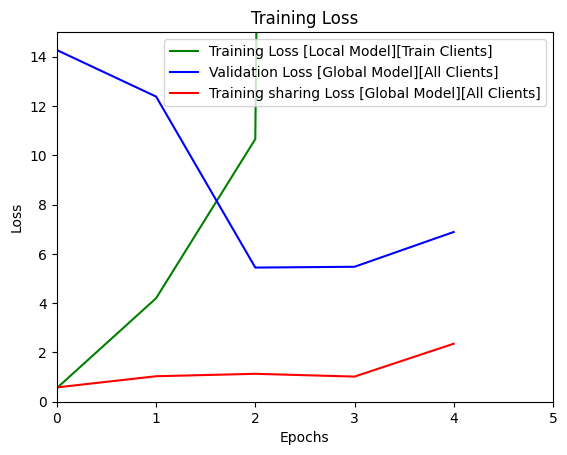

In [24]:
#PRINT LOSS GRAPH
import matplotlib.pyplot as plt
epochs = range(ROUNDS)
plt.plot(epochs, train_lost, 'g', label='Training Loss [Local Model][Train Clients]')
plt.plot(epochs, lost, 'b', label='Validation Loss [Global Model][All Clients]')
if(len(losses_share) > 0):
    plt.plot(epochs, train_share_lost, 'r', label='Training sharing Loss [Global Model][All Clients]')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([0, ROUNDS])
plt.ylim([0, 15])
plt.legend()
plt.show()

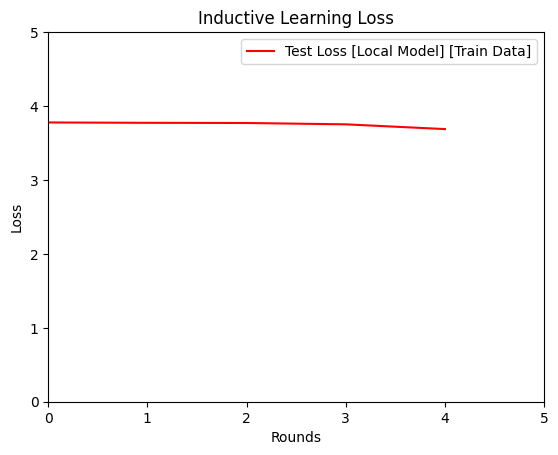

In [25]:
test_loss = []
INDUCTIVE_ROUNDS = 5
for i in range(INDUCTIVE_ROUNDS):
    test_loss.append(np.array([torch.Tensor.cpu(test_client.train_user_embeddings().detach()).numpy() for test_client in test_clients]).mean())

plt.plot(range(INDUCTIVE_ROUNDS), test_loss, 'r', label='Test Loss [Local Model] [Train Data]')
plt.title('Inductive Learning Loss')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.xlim([0, INDUCTIVE_ROUNDS])
plt.ylim([0, 5])
plt.legend()
plt.show()

In [26]:
test_acc_l = []
test_loss_l = []
for client in test_clients:
    client.model.load_state_dict(global_model.state_dict())
    test_acc, test_loss = client.evaluate_model()
    test_acc_l.append(test_acc)
    test_loss_l.append(test_loss)
print("Final:\nAccuracy: ", torch.mean(torch.Tensor(test_acc_l)).numpy(), "\nLoss: ", torch.mean(torch.Tensor(test_loss_l)).numpy())

Final:
Accuracy:  0.15737672 
Loss:  1.0927231


- During each epoch of the round, client should have created mini-batches of data on which model is trained (all mini-batches iterated in one epoch) [and they are averaged in the end of epoch and gradients of model are updated]



#### Self Notes:

- Xavier Uniform is used for weights initialization
- Node Ids are random i.e. same items don't have same id in different graphs
- How many times to include a neighbor (if there are more than one items in common)? currently: only once


#### FedGNN Paper Notes:

- In our experiments, we use graph attention network (GAT) [28] as the GNN model, 

- and use dot product to implement the rating predictor. 

- The user and item embeddings and their hidden representations learned by graph neural networks are 256-dim. 

- The gradient clipping threshold 𝛿 is set to 0.1

- The number of users used in each round of model training is 128, 

- and the total number of epoch is 3. 

- The ratio of dropout [25] is 0.2. 

- Its learning rate is 0.01. 

- The metric used in our experiments is rooted mean square error (RMSE), 

- FedAVG is used as aggregator

- The splits of datasets are the same as those used in [2], and these hyperparameters are selected according to the validation performance.

- Randomize clients subset in each round. 

- SGD is selected as the optimization algorithm (using Adam because this gets stuck)

- The round threshold 𝑇 is 2 for using neighboring users embeddings.


- **TODO** Create data mini-batches for training

- **TODO** the strength of Laplacian noise in the LDP module is set to 0.2 to achieve 1-differential privacy. 

- **TODO** The number of pseudo interacted items is set to 1,000.

- **TODO** We report the average RMSE scores over the 10 repetitions.

#### Learning on un trained client

- **TODO** Write routine to learn user embedding from item embeddings

#### Pseudo Interacted Items:

- Concretely, we sample 𝑀 items that the user has not interacted with5 , and randomly generate their gradients g𝑖 using a Gaussian distribution with the same mean and co-variance values with the real item embedding gradients. The real embedding gradients g𝑖𝑒 are combined with the pseudo item 𝑝 embedding gradients g𝑖